# Test trained model(s)

In [1]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher CHan        #
#Version: 0.3.1                      #
#Date: 2022-04-04                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()

In [2]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 611 and labels pair: 611 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_15048-2565.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_15048-2565.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_3420-5814.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_3420-5814.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_7011-6669.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_7011-6669.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_7695-1368.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_7695-1368.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_4446-1368.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_4446-1368.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_6669-16245.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_6669-16

<class 'torch.Tensor'>


Text(0.5, 1.0, 'LBL')

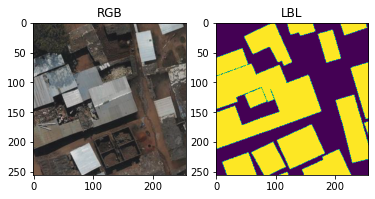

In [3]:
# plot a sample
test_pair = random.choice(Test)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

### Vanilla Four layer U-Net Baseline

In [4]:
weights_4UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "11836:1698_256oc1_Four-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_085469.pth"))
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

7763041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.167250952174072e-06, Maximum: 0.004874319303780794, Mean: 0.0019924622029066086, St dev: 0.001585200778208673
True Positive = 132.86668395996094, True Negative = 26868.443359375 False Negative = 7.556862831115723, False Positive = 38527.1328125, OA = 0.41200730204582214, IoU = 0.0034361283760517836


Text(0.5, 1.0, 'Binary Segmentation')

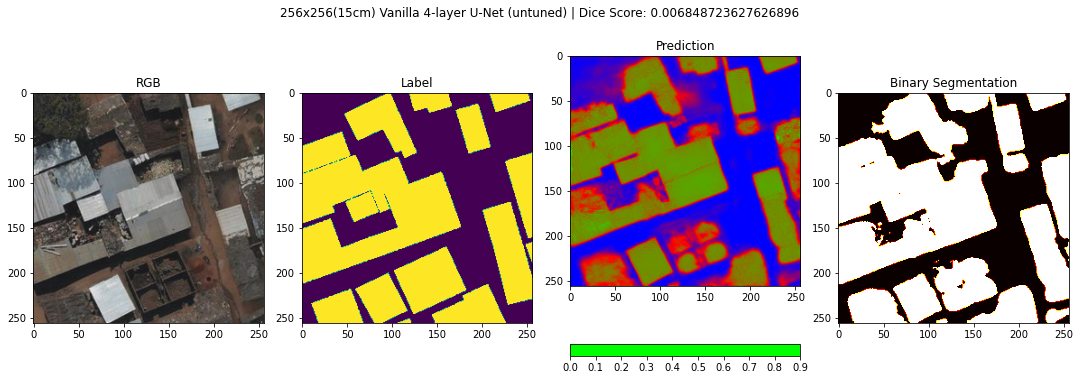

In [5]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Four_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # True-Positive, True-Negative, False-Positive
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}, OA = {4}, IoU = {5}".format(TP, TN, FN, FP, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) Vanilla 4-layer U-Net (untuned) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet

In [6]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 2.9274211391466043e-18, Maximum: 1.0, Mean: 0.23855312168598175, St dev: 0.42281869053840637
True Positive = 65.34510040283203, True Negative = 48487.921875 False Negative = 75.07843780517578, False Positive = 16907.654296875, OA = 0.7408640384674072, IoU = 0.0038329893723130226


Text(0.5, 1.0, 'Binary Segmentation')

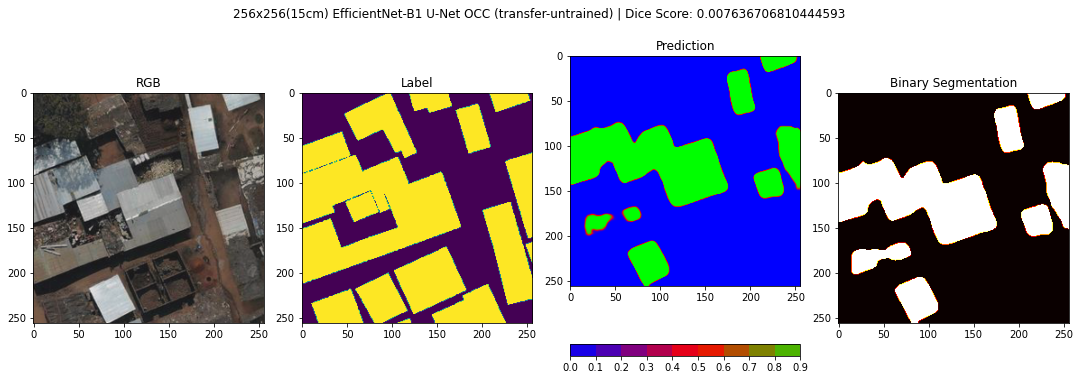

In [7]:
qubvelEB1_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # True-Positive, True-Negative, False-Positive
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}, OA = {4}, IoU = {5}".format(TP, TN, FN, FP, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet-B1 U-Net OCC (transfer-untrained) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet Vanilla (No ImageNet) Baseline

In [8]:
EB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB1_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "11836:1698_256oc1_EB1-UNet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_166869.pth"))
EB1_weights = torch.load(EB1_weights, map_location = device)
EB1_UNet.load_state_dict(EB1_weights["Model:"])
EB1_UNet.to(device = device)

print(sum(p.numel() for p in EB1_UNet.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 5.051184416515753e-06, Maximum: 0.006195890251547098, Mean: 0.002023000968620181, St dev: 0.0016118129715323448
True Positive = 131.36863708496094, True Negative = 27320.9453125 False Negative = 9.054903030395508, False Positive = 38074.6328125, OA = 0.4188890755176544, IoU = 0.00343761476688087


Text(0.5, 1.0, 'Binary Segmentation')

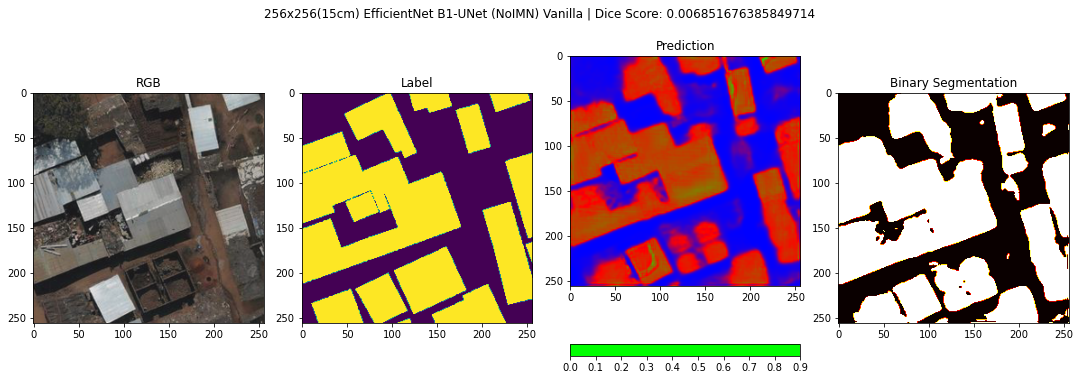

In [9]:
EB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # True-Positive, True-Negative, False-Positive
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}, OA = {4}, IoU = {5}".format(TP, TN, FN, FP, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet (NoIMN) Vanilla | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet ImageNet (trained-untuned) Baseline

In [10]:
EB1_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "11836:1698_256oc1_EB1-UNet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_166869.pth"))
IMN_weights = torch.load(IMN_weights, map_location = device)
EB1_UNet_IMN.load_state_dict(IMN_weights["Model:"])
EB1_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB1_UNet_IMN.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 7.141078413042123e-07, Maximum: 0.008413991890847683, Mean: 0.0019440746400505304, St dev: 0.001611462444998324
True Positive = 131.184326171875, True Negative = 28213.76171875 False Negative = 9.239216804504395, False Positive = 37181.81640625, OA = 0.43250954151153564, IoU = 0.0035149105824530125


Text(0.5, 1.0, 'Binary Segmentation')

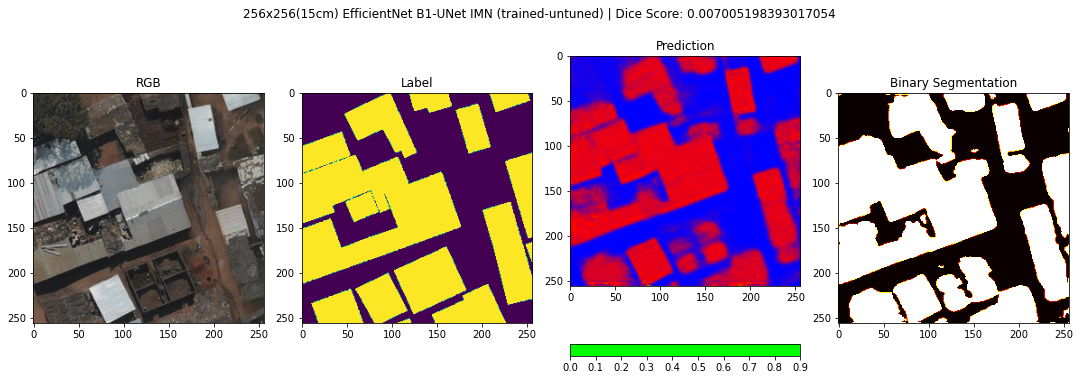

In [11]:
EB1_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # True-Positive, True-Negative, False-Positive
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}, OA = {4}, IoU = {5}".format(TP, TN, FN, FP, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet IMN (trained-untuned) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet OCC (transfer-trained) Baseline

In [12]:
EB1_UNet_OCCtrans = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

OCCtrans_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "11836:1698_256oc1_EB1-UNet-qubvel_lr1e-4_wd1e-5_b16_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_141339.pth"))
OCCtrans_weights = torch.load(OCCtrans_weights, map_location = device)
EB1_UNet_OCCtrans.load_state_dict(OCCtrans_weights["Model:"])
EB1_UNet_OCCtrans.to(device = device)

print(sum(p.numel() for p in EB1_UNet_OCCtrans.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 2.703517631985619e-09, Maximum: 0.013683195225894451, Mean: 0.0019376574782654643, St dev: 0.0017049189191311598
True Positive = 132.33724975585938, True Negative = 27600.9140625 False Negative = 8.086275100708008, False Positive = 37794.6640625, OA = 0.4231758415699005, IoU = 0.0034885185305029154


Text(0.5, 1.0, 'Binary Segmentation')

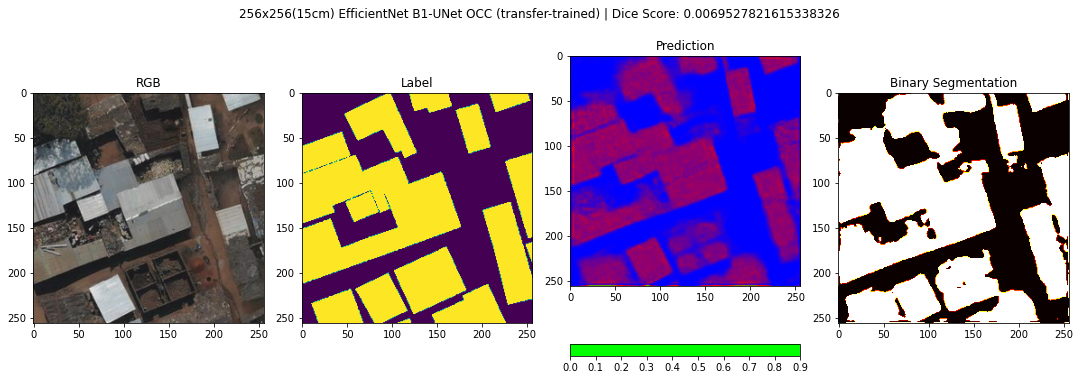

In [13]:
EB1_UNet_OCCtrans.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_OCCtrans(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Dice Loss
    dice_pred = pred_BOOL.sum(dim = [0, 1, 2])
    dice_lbl = lbl.sum(dim = [0, 1, 2])
    dice_score = 0
    dice_score += (2 * (pred_BOOL * lbl).sum(dim = [0, 1, 2]) + 1e-8) / (dice_pred + dice_lbl + 1e-8)
    dice_score = dice_score.detach().cpu().numpy()

    # True-Positive, True-Negative, False-Positive
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((1 - pred_BOOL) * (1 - lbl)).sum(dim = [0, 1, 2])
    FN = ((1 - pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (1 - lbl)).sum(dim = [0, 1, 2])
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}, OA = {4}, IoU = {5}".format(TP, TN, FN, FP, OA, IoU))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet OCC (transfer-trained) | Dice Score: {0}".format(dice_score))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')